In [1]:
import sys
import pandas as pd

sys.path

['/Users/mirandavincent/econ4161/econ4161-finalproject',
 '/Library/Frameworks/Python.framework/Versions/3.11/lib/python311.zip',
 '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11',
 '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload',
 '',
 '/Users/mirandavincent/Library/Python/3.11/lib/python/site-packages',
 '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages']

In [2]:
df = pd.read_csv('401k.csv')

In [28]:
df

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,...,educ,db,marr,male,twoearn,e401,p401,pira,net_n401,hown
0,0,0,69000,60150,8850,100,-3300,100,-3300,5550,...,12,0,1,0,0,0,0,0,-3300,1
1,0,0,78000,20000,58000,61010,61010,61010,61010,119010,...,16,0,0,0,0,0,0,0,61010,1
2,1800,0,200000,15900,184100,7549,7049,9349,8849,192949,...,11,0,1,1,1,0,0,1,8849,1
3,0,0,0,0,0,2487,-6013,2487,-6013,-6013,...,15,0,1,0,1,0,0,0,-6013,0
4,0,0,300000,90000,210000,10625,-2375,10625,-2375,207625,...,12,1,0,0,0,0,0,0,-2375,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9910,0,172,0,0,0,0,0,172,172,172,...,14,1,0,0,0,1,1,0,0,0
9911,0,4500,53000,49000,4000,936,-3664,5436,836,4836,...,12,1,1,1,0,1,1,0,-3664,1
9912,0,0,250000,150000,100000,10150,6150,10150,6150,106150,...,16,0,1,0,1,1,0,0,6150,1
9913,0,15000,63000,59000,4000,3499,-501,18499,14499,18499,...,18,1,1,0,1,1,1,0,-501,1


In [3]:
df.columns

Index(['ira', 'a401', 'hval', 'hmort', 'hequity', 'nifa', 'net_nifa', 'tfa',
       'net_tfa', 'tfa_he', 'tw', 'age', 'inc', 'fsize', 'educ', 'db', 'marr',
       'male', 'twoearn', 'e401', 'p401', 'pira', 'net_n401', 'hown'],
      dtype='object')

In [24]:
df.to_stata('401k.dta')

In [3]:
incomes = ['<10k', '10-20k', '20-30k', '30-40k', '40-50k', '50-75k', '>75k']
inc_ranges = [
  (0, 9999),
  (10000, 19999),
  (20000, 29999),
  (30000, 39999),
  (40000, 49999),
  (50000, 74999),
  (75000, max(df.inc))
]

ages = ['<30', '30-35', '36-44', '45-54', '55+']
age_ranges = [
  (0, 30),
  (30, 35),
  (36, 44),
  (45, 54),
  (55, max(df.age))
]

educs = ['<12', '12', '13-16', '16+']
educ_ranges = [
  (0, 11),
  (12, 12),
  (13, 15),
  (16, max(df.educ)),
]

for cats, ranges, source in zip(
  (incomes, ages, educs), 
  (inc_ranges, age_ranges, educ_ranges), 
  ('inc', 'age', 'educ')
):
  # Create a categorical field for each dummy 'cat' in cats.
  for cat, range_ in zip(cats, ranges):
    df[cat] = ((df[source] >= range_[0]) & (df[source] <= range_[1])).astype(int)
    # Keep track of noobs.
    noobs = df[df[cat] == 1].shape[0]
    print(f'Created category: {cat}. Noobs: {noobs}.')

Created category: <10k. Noobs: 636.
Created category: 10-20k. Noobs: 1948.
Created category: 20-30k. Noobs: 2074.
Created category: 30-40k. Noobs: 1712.
Created category: 40-50k. Noobs: 1204.
Created category: 50-75k. Noobs: 1572.
Created category: >75k. Noobs: 767.
Created category: <30. Noobs: 1773.
Created category: 30-35. Noobs: 2079.
Created category: 36-44. Noobs: 2949.
Created category: 45-54. Noobs: 2136.
Created category: 55+. Noobs: 1323.
Created category: <12. Noobs: 1272.
Created category: 12. Noobs: 3736.
Created category: 13-16. Noobs: 2424.
Created category: 16+. Noobs: 2483.


In [16]:
import statsmodels.api as sm

# Estimate the effect of 401k participation on three variables 
# -- total wealth, net financial assets, and net non 401k assets. 
# To do this we can estimate some series of models on observations
# not involved in a 401k plan, and predict the outcome variables
# for those involved in a 401k plan. The difference between them should
# be the delta we're interested in.

nop401 = df[df.p401 == 0]
p401 = df[df.p401 == 1]

# Model 1 -- Naive OLS.
X_list = ['marr', 'fsize', 'twoearn', 'db', 'pira', 'hown']
X_list.extend(incomes)
X_list.extend(ages)
X_list.extend(educs)

# Train model on non participation in 401k group.
X = nop401[X_list]
sm.add_constant(X)
res = sm.OLS(nop401.tw, X).fit()
print(res.summary())

# Predict participation in 401k group total wealth with model results.
X2 = p401[X_list]
sm.add_constant(X2)

pred = res.predict(X2)
diff = p401.tw - pred
print(f'\nMean: {round(diff.mean(), 2)}')
print(f'Std Dev: {round(diff.std(), 2)}')
print(f'Num values with pred smaller than actual: {len(diff[diff > 0])}')
print(f'Num values with pred greater than actual: {len(diff[diff < 0])}')

                            OLS Regression Results                            
Dep. Variable:                     tw   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     177.0
Date:                Wed, 19 Nov 2025   Prob (F-statistic):               0.00
Time:                        10:53:14   Log-Likelihood:                -93358.
No. Observations:                7321   AIC:                         1.868e+05
Df Residuals:                    7299   BIC:                         1.869e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
marr        9013.7969   3081.867      2.925      0.0

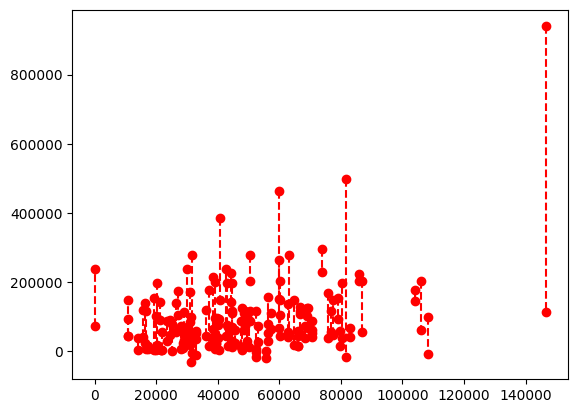

In [14]:
import matplotlib.pyplot as plt
import numpy as np

n = 100
sample = p401.sample(n)

x = sample.inc.to_numpy()
y1 = sample.tw.to_numpy()
y2 = pred.to_numpy()

for i in range(0, n):
  plt.plot([x[i], x[i]], [y1[i], y2[i]], 'ro--')

# plt.show()